In [ ]:
from wire_4 import *
import gpip_package
import sys
import pyvisa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import pandas as pd
import scipy
from scipy.optimize import curve_fit
import re
from pathlib import Path

In [2]:
def find_delta_t(ch2, ch4_signal: np.ndarray) -> int:
    # Calculate peak of echo
    smoothed = scipy.ndimage.gaussian_filter(ch4_signal, 20)
    drange = np.max(smoothed) - np.min(smoothed)
    
    filter = smoothed.shape[0] - np.argmin(smoothed[::-1])
    
    # Iteratively adjust prominence to find exactly 1 peak
    min_prom = drange * 0.02
    max_prom = drange * 0.8
    
    for i in range(100):  # Max iterations to prevent infinite loop
        prominance = (min_prom, max_prom)
        peaks, _ = scipy.signal.find_peaks(-smoothed[filter:], prominence=prominance)
        
        if len(peaks) == 1:
            break
        elif len(peaks) > 1:
            # Too many peaks, increase lower bound
            min_prom = min_prom + (max_prom - min_prom) * 0.1
        else:
            # No peaks found, decrease lower bound
            min_prom = min_prom * 0.5
            
        if min_prom >= max_prom:
            raise ValueError("Cannot find exactly 1 peak with valid prominence range")
    else:
        print("Warning: Failed to find exactly 1 peak after maximum iterations")
        return np.nan
    
    echo_peak_idx = peaks[0]

    # Find falling edge of pulse
    mask = ch2 > (np.min(ch2) + drange * 0.05)
    filter_idx = np.argwhere(ch2 == np.median(ch2[mask]))[-1]

    return echo_peak_idx - filter_idx

def get_voltage_diff(ch4) -> float:
    smoothed = scipy.ndimage.gaussian_filter(ch4, 20)
    drange = np.max(smoothed) - np.min(smoothed)
    
    filter = smoothed.shape[0] - np.argmin(smoothed[::-1])
    
    # Iteratively adjust prominence to find exactly 1 peak
    min_prom = drange * 0.001
    max_prom = drange * 0.8
    
    for i in range(100):  # Max iterations to prevent infinite loop
        prominance = (min_prom, max_prom)
        peaks, _ = scipy.signal.find_peaks(-smoothed[filter:], prominence=prominance)
        
        if len(peaks) == 1:
            break
        elif len(peaks) > 1:
            # Too many peaks, increase lower bound
            min_prom = min_prom + (max_prom - min_prom) * 0.1
        else:
            # No peaks found, decrease lower bound
            min_prom = min_prom * 0.5
            
        if min_prom >= max_prom:
            raise ValueError("Cannot find exactly 1 peak with valid prominence range")
    else:
        print("Warning: Failed to find exactly 1 peak after maximum iterations")
        return np.nan
    echo_peak_idx = peaks[0]

    ref_voltage = np.percentile(smoothed, 65)
    peak_voltage = smoothed[echo_peak_idx + filter]

    return peak_voltage - ref_voltage

def extract_delta_times(df):
    """
    Extract delta times from column labels that contain 'D' followed by scientific notation.
    Returns a list of delta times corresponding to each column.
    """
    delta_times = []
    
    for col in df.columns:
        # Search for 'D' followed by scientific notation (e.g., D1.5e-3, D2.5E+2)
        match = re.search(r'D([-+]?\d+\.?\d*[eE][-+]?\d+)', str(col))
        if match:
            delta_time = float(match.group(1))
            delta_times.append(delta_time)
        else:
            delta_times.append(None)  # No match found
    
    return np.asarray(delta_times)

def get_unique_delta_times(df):
    """
    Get unique delta times from columns (accounting for triplet pattern).
    Returns unique delta times in order of appearance.
    """
    delta_times = extract_delta_times(df)
    unique_times = []
    seen = set()
    
    for dt in delta_times:
        if dt is not None and dt not in seen:
            unique_times.append(dt)
            seen.add(dt)
    
    return np.asarray(unique_times)

## Data Collection

In [3]:
gpid = gpip_package.PrologixGPIB(r'COM3')
HP_PSU_ADDR = 5
SIGNAL_GEN_ADDR = 6
DELAY_GEN_ADDR = 15

AttributeError: module 'serial' has no attribute 'Serial'

In [6]:
devices = gpid.scan_bus().split('\n')[:-1]

5 : HEWLETT-PACKARD,E3632A,0,2.5-6.1-2.1
6 : FLUKE, 45, 6165018, 1.7 D1.0
15 : Stanford Research Systems,DG645,s/n002313,ver1.14.10E


In [ ]:
# Power supply for magnet
gpip_package.addr(HP_PSU_ADDR)
gpip_package('output:state 1')

In [2]:
OSCILLOSCOPE_IP = "35.15.225.124"

rm = pyvisa.ResourceManager('@py')
oscilloscope = rm.open_resource(f"TCPIP::{OSCILLOSCOPE_IP}::INSTR")

oscilloscope.timeout = 5000  # 5 seconds
oscilloscope.write_termination = '\n'
oscilloscope.read_termination = '\n'

# Get waveform parameters
def get_waveform_params(oscil):
    return {
        'ymult'       : float(oscil.query("WFMPRE:YMULT?")),
        'yoff'       : float(oscil.query("WFMPRE:YOFF?")),
        'yzero'      : float(oscil.query("WFMPRE:YZERO?")),
        'xzero'      : float(oscil.query("WFMPRE:XZERO?")),
        'time_scale' : float(oscil.query("HORizontal:SCAle?")),
        't_offset'   : int(float(oscil.query("WFMPRE:xzero?")) / float(oscil.query("WFMPRE:XINCR?")))
    }


# Set up acquisition parameters
oscilloscope.write("DATa:STOP 30000")
oscilloscope.write("ACQuire:NUMAVg 512")

dev_settings = get_waveform_params(oscilloscope)

def read_scope(oscil, data_wait=1, params = None):
    '''Return a waveform from the oscilloscope after clearing any old data
    and then waiting for data_wait seconds (useful to allow averaging to converge)
    '''
    if params is None:
        params = get_waveform_params(oscil)
    # restart acquisition
    oscil.write("ACQuire:STATE 0")
    oscil.write("ACQuire:STATE 1")
    # Read data from oscilloscope
    time.sleep(data_wait)
    oscil.write("CURVE?")
    data = oscil.read_raw()
    data = np.frombuffer(data, dtype=np.int8)
    data = params['yzero'] + params['ymult'] * (data.astype(dtype=np.int64) - 128)
    return data

def set_delay(gp, delay_sec, start = 3, end = 4, ID = DELAY_GEN_ADDR):
    '''Sets delay in seconds
        Pulse 1 : 1,2
        Delay   : 3,4
        Pulse 2 : 
    '''
    gp.addr(15)
    gp(f'DLAY {end},{start},{delay_sec}')

def set_current(gp, current):
    gp(f'current {current}')
    gp('voltage max')
    gp('output:state 1')

In [3]:
def run_trial(delays, concentration,sample = 'Fe', chanels = [1,2,3,4], oscil = oscilloscope, gp = gpid, log = True):
    data = np.empty((10008, len(delays) * len(chanels)))
    header = ''
    params = get_waveform_params(oscil)
    for j, delay in enumerate(delays):
        set_delay(gp, delay, 3, 4)
        time.sleep(2)
        print(f'{j+1} of {len(delays)}: {delay:.3e}')
        for i, chr in enumerate(chanels):
            header += f'CH{chr} D{delay:.4e}, '
            oscil.write(f"DATa:SOUrce CH{chr}")
            time.sleep(0.5)
            buffer = read_scope(oscil, params = params)
            data[:, j * len(chanels) + i] = buffer
    if log:
        np.savetxt(f'T1{sample}M{concentration:.2e}.csv', data, delimiter=',', header = header)

In [3]:
set_delay(gpid, 3.0e-5, 2, 3)
set_delay(gpid, 2.9e-4, 3, 4)
set_delay(gpid, 6.0e-5, 4, 5)

In [4]:
rng = np.random.default_rng(0x105)

In [22]:
delays = np.linspace(4e-4, 1.2e-3, num = 15)
rng.shuffle(delays)

run_trial(delays, np.nan, sample = 'Cu2', log = True)

1 of 15: 1.086e-03
2 of 15: 9.143e-04
3 of 15: 4.571e-04
4 of 15: 4.000e-04
5 of 15: 6.857e-04
6 of 15: 1.200e-03
7 of 15: 5.714e-04
8 of 15: 6.286e-04
9 of 15: 9.714e-04
10 of 15: 1.143e-03
11 of 15: 5.143e-04
12 of 15: 1.029e-03
13 of 15: 8.000e-04
14 of 15: 7.429e-04
15 of 15: 8.571e-04


In [7]:
voltages = pd.read_csv(r'T1CuM2.50e-01.csv')

In [8]:
time_scale = 0.0001
t_offset = 0

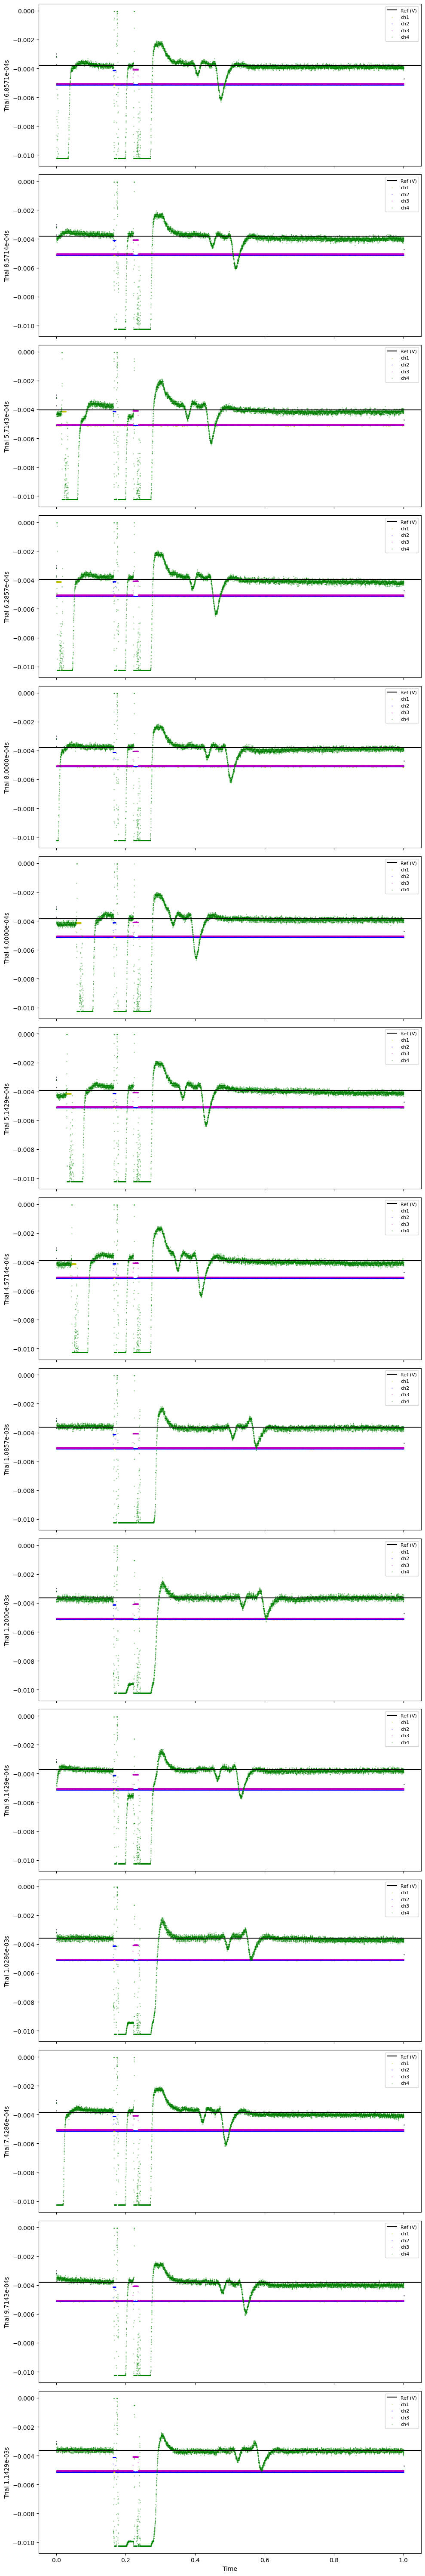

In [ ]:
ch4_signal = voltages.to_numpy()
N, M = ch4_signal.shape
T = M // 4
labels = [x[6:] for x in voltages.columns]
times = time_scale * np.linspace(t_offset, t_offset + N, num=N)

fig, axes = plt.subplots(T, 1, figsize=(10, 4*T), sharex=True)

if T == 1:
    axes = [axes]  # handle T=1 case

for t in range(T):
    ch1 = ch4_signal[:, 4*t]
    ch2 = ch4_signal[:, 4*t + 1]
    ch3 = ch4_signal[:, 4*t + 2]
    ch4 = ch4_signal[:, 4*t + 3]

    # Compute reference and pre-sample from ch2
    mask_ref = np.abs(np.mean(ch4) - ch4) < (np.max(ch4) - np.min(ch4)) * 0.1
    ref_1 = np.percentile(ch4, 65)
    reference_0 = np.median(ch4[mask_ref])

    ax = axes[t]
    #ax.axhline(reference_0, c='k', label='ref_0')
    ax.axhline(ref_1, c='k', label='Ref (V)')

    ax.scatter(times, ch1, c='y', alpha=0.4, s=0.5, label='ch1')
    ax.scatter(times, ch2, c='b', alpha=0.4, s=0.5, label='ch2')
    ax.scatter(times, ch3, c='m', alpha=0.4, s=0.5, label='ch3')
    ax.scatter(times, ch4, c='g', alpha=0.4, s=0.5, label='ch4')

    ax.set_ylabel(f"Trial {labels[4*t + 1]}s")
    ax.legend(fontsize=8, loc='upper right')

axes[-1].set_xlabel("Time")
fig.tight_layout()
plt.show()


## T2 Calculations

In [157]:
t2_data = pd.read_csv(r'FeM5.00e-03.csv')
t2_data

,# CH1 D2.1843e-03,CH2 D2.1843e-03,CH4 D2.1843e-03,CH1 D6.0571e-04,CH2 D6.0571e-04,CH4 D6.0571e-04,CH1 D1.7107e-03,CH2 D1.7107e-03,CH4 D1.7107e-03,CH1 D2.5000e-03,...,CH1 D2.3421e-03,CH2 D2.3421e-03,CH4 D2.3421e-03,CH1 D9.2143e-04,CH2 D9.2143e-04,CH4 D9.2143e-04,CH1 D1.2371e-03,CH2 D1.2371e-03,CH4 D1.2371e-03,
0,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,...,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,-0.00372,NaN
1,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,...,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,-0.00300,NaN
2,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,...,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,-0.00316,NaN
3,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,...,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,NaN
4,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,...,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,-0.00320,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10003,-0.00512,-0.00512,-0.00484,-0.00512,-0.00512,-0.00488,-0.00512,-0.00512,-0.00504,-0.00512,...,-0.00512,-0.00512,-0.00472,-0.00512,-0.00512,-0.00496,-0.00508,-0.00512,-0.00520,NaN
10004,-0.00512,-0.00512,-0.00496,-0.00512,-0.00512,-0.00492,-0.00512,-0.00512,-0.00504,-0.00512,...,-0.00512,-0.00512,-0.00480,-0.00512,-0.00512,-0.00496,-0.00508,-0.00512,-0.00516,NaN
10005,-0.00512,-0.00508,-0.00484,-0.00512,-0.00512,-0.00504,-0.00508,-0.00512,-0.00496,-0.00512,...,-0.00512,-0.00512,-0.00480,-0.00512,-0.00512,-0.00488,-0.00512,-0.00512,-0.00500,NaN
10006,-0.00512,-0.00512,-0.00484,-0.00512,-0.00512,-0.00492,-0.00512,-0.00512,-0.00500,-0.00512,...,-0.00512,-0.00512,-0.00480,-0.00508,-0.00512,-0.00480,-0.00512,-0.00512,-0.00492,NaN


-0.18253066499237125


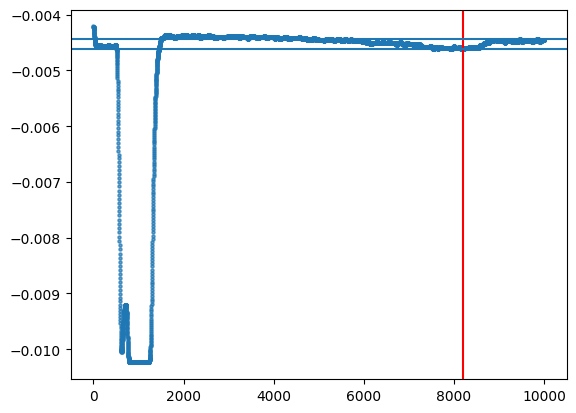

In [ ]:
ch4 = t2_data.iloc[:, 19 * 3 + 2]
times = np.arange(ch4.shape[0])
smoothed = scipy.ndimage.gaussian_filter(ch4, 20)
drange = np.max(smoothed) - np.min(smoothed)
prominance = drange*0.02, drange*0.8

filter = smoothed.shape[0] - np.argmin(smoothed[::-1])

peaks, _ = scipy.signal.find_peaks(-smoothed[filter:], prominence=prominance)
for idx in peaks:
    plt.axvline(idx+filter, c = 'r')
plt.scatter(times, smoothed, s = 5, alpha = 0.7)


ref_voltage = np.percentile(smoothed, 65)
peak_voltage = smoothed[peaks[0]+filter]
print((peak_voltage - ref_voltage)*1000)
plt.axhline(ref_voltage)
plt.axhline(peak_voltage)

In [66]:
ch4 = t2_data.iloc[:, 7]
times = np.arange(ch4.shape[0])
drange = np.max(smoothed) - np.min(smoothed)
prominance = drange*0.05, drange*0.8
mask = ch4 > (np.min(ch4) + drange * 0.05)

filter_idx = np.argwhere(ch4 == np.median(ch4[mask]))[-1]
plt.axvline(filter_idx, c = 'r')
plt.scatter(times[mask], ch4[mask], s = 5, alpha = 0.7)

NameError: name 't2_data' is not defined

In [3]:
def get_times_t2(data):
    
    time_trial_count = len(data.columns)//3
    time_data = np.empty((time_trial_count, 3))
    #### VERIFY DUMBASS
    # TODO: Check Time scale
    # Todo: Update both getimes methods approriately
    time_scale = 0.0001
    
    times = get_unique_delta_times(data)

    for i in range(time_trial_count):
        ch1 = data.iloc[:, 3*i + 0]
        ch2 = data.iloc[:, 3*i + 1]
        ch4 = data.iloc[:, 3*i + 2]

        dt_idx = find_delta_t(ch2, ch4)
        delta_t = dt_idx * time_scale

        voltage = get_voltage_diff(ch4)

        time_data[i, 0] = times[i]
        time_data[i, 1] = delta_t
        time_data[i, 2] = voltage
    
    return time_data

In [4]:
from scipy.optimize import curve_fit

# Extract x and y from your data
time = data[:, 1]
amplitude = data[:, 2]

# Define exponential function: y = a * exp(b * x)
def exp_func(x, a, b):
    return a * np.exp(b * x)

# Fit the exponential model
popt, pcov = curve_fit(exp_func, time, amplitude, p0=[1, 1])
a_fit, b_fit = popt

# Generate fitted values
y_fit = exp_func(time, a_fit, b_fit)

# Calculate residuals
residuals = amplitude - y_fit

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), 
                                gridspec_kw={'height_ratios': [3, 1]})

# Plot 1: Data and fitted curve
ax1.scatter(time, amplitude, alpha=0.6, label='Data', color='blue')
x_smooth = np.linspace(time.min(), time.max(), 200)
y_smooth = exp_func(x_smooth, a_fit, b_fit)
ax1.plot(x_smooth, y_smooth, 'r-', linewidth=2, 
         label=f'Fit: y = {a_fit:.3f} * exp({b_fit:.3f} * x)')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Exponential Regression')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals
ax2.scatter(time, residuals, alpha=0.6, color='green')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=1)
ax2.set_xlabel('x')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print fit parameters and statistics
print(f"Fitted parameters:")
print(f"  a = {a_fit:.6f}")
print(f"  b = {b_fit:.6f}")
print(f"\nResidual statistics:")
print(f"  Mean residual: {np.mean(residuals):.6f}")
print(f"  Std of residuals: {np.std(residuals):.6f}")
print(f"  Sum of squared residuals: {np.sum(residuals**2):.6f}")

# R-squared value
ss_res = np.sum(residuals**2)
ss_tot = np.sum((amplitude - np.mean(amplitude))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"  R-squared: {r_squared:.6f}")

NameError: name 'data' is not defined

In [ ]:
def exp_func(x, a, b):
    return a * np.exp(-b * x)

def find_t2(pd_data: pd.DataFrame, plot: bool = False):
    data = get_times_t2(pd_data)
    mask = ~np.isnan(data).any(axis=1)
    data = data[mask]
    time = data[:, 1]
    amplitude = data[:, 2]
    
    # Fit the exponential model
    popt, pcov = curve_fit(exp_func, time, amplitude, p0=[1, 1])
    a_fit, b_fit = popt
    
    # Generate fitted values
    y_fit = exp_func(time, a_fit, b_fit)

    # Calculate residuals
    residuals = amplitude - y_fit

    # R-squared value
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((amplitude - np.mean(amplitude))**2)
    r_squared = 1 - (ss_res / ss_tot)
    

    if not plot:
        return b_fit, r_squared

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), 
                                    gridspec_kw={'height_ratios': [3, 1]})

    # Plot 1: Data and fitted curve
    ax1.scatter(time, amplitude, alpha=0.6, label='Data', color='blue')
    x_smooth = np.linspace(time.min(), time.max(), 200)
    y_smooth = exp_func(x_smooth, a_fit, b_fit)
    ax1.plot(x_smooth, y_smooth, 'r-', linewidth=2, 
            label=f'Fit: y = {a_fit:.3f} * exp({b_fit:.3f} * x)')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Exponential Regression')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Residuals
    ax2.scatter(time, residuals, alpha=0.6, color='green')
    ax2.axhline(y=0, color='r', linestyle='--', linewidth=1)
    ax2.set_xlabel('x')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residuals')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print fit parameters and statistics
    print(f"Fitted parameters:")
    print(f"  a = {a_fit:.6f}")
    print(f"  b = {b_fit:.6f}")
    print(f"\nResidual statistics:")
    print(f"  Mean residual: {np.mean(residuals):.6f}")
    print(f"  Std of residuals: {np.std(residuals):.6f}")
    print(f"  Sum of squared residuals: {np.sum(residuals**2):.6f}")

    print(f"  R-squared: {r_squared:.6f}")
    
    return b_fit, r_squared

In [ ]:
def import_csv_files(file_path, file_beginning):
    """
    Import CSV files matching a pattern with 'M' followed by a numeric value.
    
    Parameters:
    -----------
    file_path : str
        Directory path containing the CSV files
    file_beginning : str
        Beginning pattern of the filename (before the 'M' and numeric value)
    
    Returns:
    --------
    dict
        Dictionary mapping numeric values to pandas DataFrames
        
    Example:
    --------
    # For files like: "data_M1.5e3.csv", "data_M2.0e4.csv"
    result = import_csv_files("/path/to/files", "data_")
    # Returns: {1500.0: df1, 20000.0: df2}
    """
    file_dict = {}
    
    # Create Path object for easier path handling
    path = Path(file_path)
    
    # Check if directory exists
    if not path.exists():
        raise ValueError(f"Directory not found: {file_path}")
    
    # Pattern to match: file_beginning + M + number in scientific notation + .csv
    # This pattern captures numbers like: 1.5e3, 2e4, 3.14e-2, etc.
    pattern = re.compile(
        rf"^{re.escape(file_beginning)}M([\d.]+e[+-]?\d+)\.csv$",
        re.IGNORECASE
    )
    
    # Iterate through files in directory
    for file in path.iterdir():
        if file.is_file():
            match = pattern.match(file.name)
            if match:
                # Extract the numeric value in scientific notation
                numeric_str = match.group(1)
                numeric_value = float(numeric_str)
                
                # Read the CSV file
                try:
                    df = pd.read_csv(file)
                    file_dict[numeric_value] = df
                except Exception as e:
                    print(f"Error reading {file.name}: {e}")
    
    # Sort dictionary by keys for consistent ordering
    file_dict = dict(sorted(file_dict.items()))
    
    if not file_dict:
        print(f"No matching CSV files found in {file_path}")
        print(f"Looking for pattern: {file_beginning}M<number>e<exponent>.csv")
    
    return file_dict

In [185]:
data_dict = import_csv_files(r".", "Cu")
cu_fuck = []

for m_value, df in data_dict.items():
    t_2, r_squared = find_t2(df)
    cu_fuck.append((m_value, t_2, r_squared))
    print(f'Cu Concentration: {m_value:.4e} \n\tT_2: {t_2:.4e} \n\t R^2: {r_squared:.3f}')

data_dict = import_csv_files(r".", "Fe")
fe_fuck = []

for m_value, df in data_dict.items():
    t_2, r_squared = find_t2(df)
    fe_fuck.append((m_value, t_2, r_squared))
    print(f'Fe Concentration: {m_value:.4e} \n\tT_2: {t_2:.4e} \n\t R^2: {r_squared:.3f}')

C:\Users\volca\AppData\Local\Temp\ipykernel_18084\923934287.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time_data[i, 1] = delta_t


Cu Concentration: 4.8000e-02 
	T_2: 5.0603e-01 
	 R^2: 0.953
Cu Concentration: 8.0000e-02 
	T_2: 7.4547e-01 
	 R^2: 0.974
Cu Concentration: 1.0000e-01 
	T_2: 8.5592e-01 
	 R^2: 0.975
Cu Concentration: 1.6000e-01 
	T_2: 1.3914e+00 
	 R^2: 0.991
Cu Concentration: 2.5000e-01 
	T_2: 2.2840e+00 
	 R^2: 0.991
Cu Concentration: 3.2000e-01 
	T_2: 3.2720e+00 
	 R^2: 0.990
Cu Concentration: 4.8000e-01 
	T_2: 4.5762e+00 
	 R^2: 0.994
Cu Concentration: 6.6000e-01 
	T_2: 7.0840e+00 
	 R^2: 0.986
Cu Concentration: 7.5000e-01 
	T_2: 8.5366e+00 
	 R^2: 0.959


C:\Users\volca\AppData\Local\Temp\ipykernel_18084\923934287.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time_data[i, 1] = delta_t


Fe Concentration: 2.5000e-03 
	T_2: -7.0178e-02 
	 R^2: 0.004
Fe Concentration: 5.0000e-03 
	T_2: 3.1329e-01 
	 R^2: 0.823
Fe Concentration: 1.0000e-02 
	T_2: 4.8125e-01 
	 R^2: 0.944
Fe Concentration: 1.5000e-02 
	T_2: 9.9888e-01 
	 R^2: 0.990
Fe Concentration: 2.5000e-02 
	T_2: 1.9692e+00 
	 R^2: 0.992
Fe Concentration: 3.0000e-02 
	T_2: 2.4700e+00 
	 R^2: 0.994
Fe Concentration: 4.0000e-02 
	T_2: 3.0227e+00 
	 R^2: 0.994
Fe Concentration: 5.0000e-02 
	T_2: 4.9577e+00 
	 R^2: 0.910


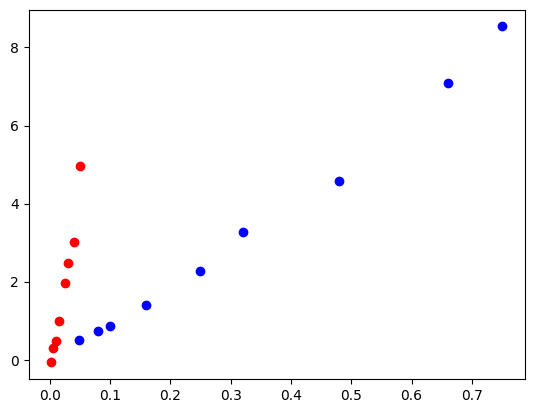

In [186]:
cu_fuck = np.asarray(cu_fuck)
fe_fuck = np.asarray(fe_fuck)

plt.scatter(cu_fuck[:,0], cu_fuck[:,1], c = 'b')
plt.scatter(fe_fuck[:,0], fe_fuck[:,1], c = 'r')


## T1 Calulations

In [3]:
def get_times_t1(data):
    
    time_trial_count = len(data.columns)//4
    time_data = np.empty(4, len(data.rows))
    #### VERIFY DUMBASS
    # TODO: Check Time scale
    # Todo: Update both getimes methods approriately
    time_scale = 0.0001
    
    times = get_unique_delta_times(data)

    for i in range(time_trial_count):
        ch1 = data.iloc[:, 4*i + 0]
        ch2 = data.iloc[:, 4*i + 1]
        ch3 = data.iloc[:, 4*i + 2]
        ch4 = data.iloc[:, 4*i + 3]

        dt_idx = find_delta_t(ch2, ch4)
        delta_t = dt_idx * time_scale

        voltage = get_voltage_diff(ch4)

        time_data[i, 0] = times[i]
        time_data[i, 1] = ch1
        time_data[i, 2] = ch2
        time
        time_data[i, 4] = voltage
    
    return time_data

In [4]:
def get_peak_idxs(ch4) -> list:
    smoothed = scipy.ndimage.gaussian_filter(ch4, 20)
    drange = np.max(smoothed) - np.min(smoothed)
    
    filter = smoothed.shape[0] - np.argmin(smoothed[::-1])
    
    # Iteratively adjust prominence to find exactly 1 peak
    min_prom = drange * 0.001
    max_prom = drange * 0.8
    
    for i in range(100):  # Max iterations to prevent infinite loop
        prominance = (min_prom, max_prom)
        peaks, _ = scipy.signal.find_peaks(-smoothed[filter:], prominence=prominance)
        
        if len(peaks) == 2:
            return peaks
        elif len(peaks) > 2:
            # Too many peaks, increase lower bound
            min_prom = min_prom + (max_prom - min_prom) * 0.1
        else:
            # No peaks found, decrease lower bound
            min_prom = min_prom * 0.5
            
        if min_prom >= max_prom:
            print("Cannot find exactly 1 peak with valid prominence range")
            return [np.nan, np.nan]
    else:
        print("Warning: Failed to find exactly 1 peak after maximum iterations")
        return [np.nan, np.nan]

In [5]:
def sort_dataframe_by_time_array(df):
    """
    Sort dataframe columns in groups of 4 according to a time array.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataframe with columns in groups of 4, where each group has randomized time values
    
    Returns:
    --------
    pd.DataFrame
        Dataframe with column groups sorted according to time_array
    
    Example:
    --------
    # Assuming first row contains time values for each group
    df_sorted = sort_dataframe_by_time_array(df, time_array)
    """
    time_array = get_unique_delta_times(df)
    n_cols = len(df.columns)
    n_groups = n_cols // 4
    
    # Get the sorted order of the time array
    sorted_indices = np.argsort(time_array)
    
    # Build new column order based on sorted indices
    new_col_order = []
    for sorted_idx in sorted_indices:
        # Add all 4 columns from this group
        new_col_order.extend(range(sorted_idx * 4, (sorted_idx + 1) * 4))
    
    # Return dataframe with reordered columns
    return df.iloc[:, new_col_order]

def find_two_peaks_by_distance(peaks, properties, delta_t, tolerance=0.1):
    """
    Find the 2 peaks with the largest prominence that are approximately delta_t apart.
    
    Parameters:
    -----------
    peaks : ndarray
        Indices of peaks from find_peaks
    properties : dict
        Properties dictionary from find_peaks (must contain 'prominences')
    delta_t : float
        Target distance between peaks
    tolerance : float, optional
        Relative tolerance for distance matching (default: 0.1 means ±10%)
        
    Returns:
    --------
    tuple
        (peak1_idx, peak2_idx, distance, prominences)
        Returns (None, None, None, None) if no suitable pair is found
    """
    if 'prominences' not in properties:
        raise ValueError("Properties must contain 'prominences'. Run find_peaks with prominence parameter.")
    
    if len(peaks) < 2:
        return None, None, None, None
    
    prominences = properties['prominences']
    # Define acceptable distance range
    min_dist = delta_t * (1 - tolerance)
    max_dist = delta_t * (1 + tolerance)
    
    best_pair = None
    best_combined_prominence = -np.inf
    
    # Check all pairs of peaks
    for i in range(len(peaks)):
        for j in range(i + 1, len(peaks)):
            distance = abs(peaks[j] - peaks[i])
            
            # Check if distance is within tolerance
            if min_dist <= distance <= max_dist:
                combined_prominence = prominences[i] + prominences[j]
                
                if combined_prominence > best_combined_prominence:
                    best_combined_prominence = combined_prominence
                    best_pair = (i, j, distance, (prominences[i], prominences[j]))
    
    if best_pair is None:
        return None, None, None, None
    
    i, j, distance, prominences = best_pair
    return peaks[i], peaks[j], distance, prominences

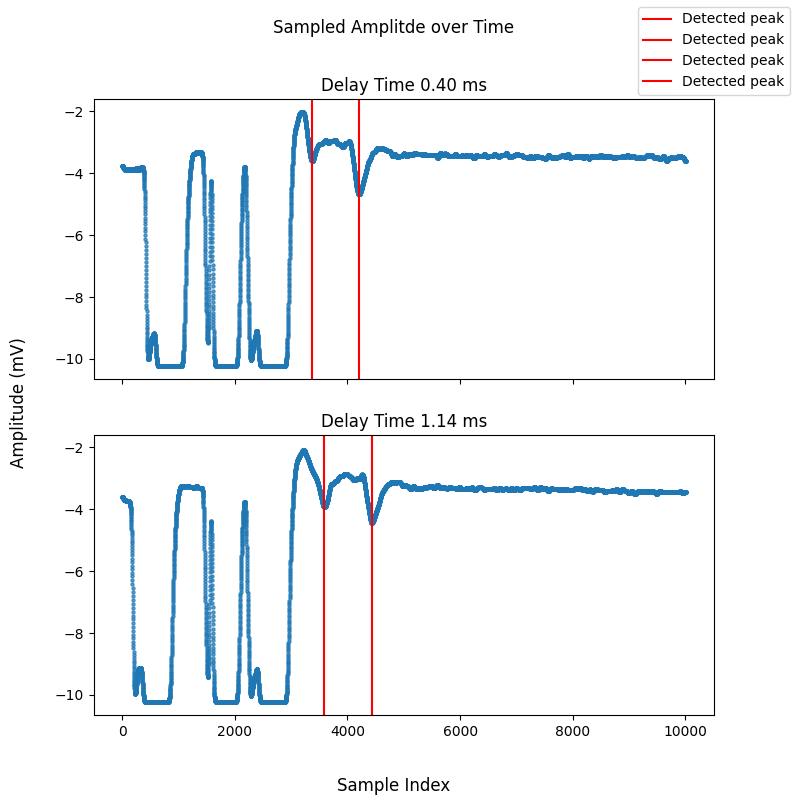

In [22]:
t1_test_data = pd.read_csv(r'T1FeM5.00e-02.csv')
t1_test_data = sort_dataframe_by_time_array(t1_test_data)
sorted_times = np.sort(get_unique_delta_times(t1_test_data))

trial_count = len(t1_test_data.columns)//4
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize = (8, 8))
fig.suptitle('Sampled Amplitde over Time')
fig.supylabel('Amplitude (mV)')
fig.supxlabel('Sample Index')
for run,idx in enumerate(range(0, 10, 8)): #range(trial_count):
    axs[run].set_title(f'Delay Time {1000*sorted_times[idx]:0.2f} ms')
    ch1 = t1_test_data.iloc[:,run*4 + 0]
    ch2 = t1_test_data.iloc[:,run*4 + 1]
    ch3 = t1_test_data.iloc[:,run*4 + 2]
    ch4 = t1_test_data.iloc[:,run*4 + 3]
    times = np.arange(ch4.shape[0])
    smoothed = scipy.ndimage.gaussian_filter(ch4, 20)
    drange = np.max(smoothed) - np.min(smoothed)
    prominance = drange*0.02, drange*0.7

    time_scale = 0.000_001
    filter = smoothed.shape[0] - np.argmin(smoothed[::-1])

    #Falling edge
    pulse_drange = np.max(ch1) - np.min(ch1)
    ch1_mask = ch1 > (np.min(ch1) + pulse_drange * 0.05)
    ch1_filter_idx = np.argwhere(ch1 == np.median(ch1[ch1_mask]))[-1]
    
    ch2_mask = ch2 > (np.min(ch2) + pulse_drange * 0.05)
    ch2_filter_idx = np.argwhere(ch2 == np.median(ch2[ch2_mask]))[-1]
    
    ch3_mask = ch3 > (np.min(ch3) + pulse_drange * 0.05)
    ch3_filter_idx = np.argwhere(ch3 == np.median(ch3[ch3_mask]))[-1]
    

    peaks, info = scipy.signal.find_peaks(-smoothed[ch3_filter_idx[0]:], prominence = prominance)
    
    #for idx in peaks:
    #    axs[run].axvline(idx + ch3_filter_idx[0], c = 'g')
    *peaks, dist, comb_prom = find_two_peaks_by_distance(peaks, info, 
                            (ch3_filter_idx - ch2_filter_idx), tolerance=0.15)
    
    axs[run].scatter(times, 1000*smoothed, s = 5, alpha = 0.7)
    #axs[run].axvline(ch1_filter_idx, c = 'k')
    '''    axs[run].scatter(times, ch1, s = 0.1, c = 'k')
        axs[run].scatter(times, ch2, s = 0.1, c = 'g')
        axs[run].scatter(times, ch3, s = 0.1, c = 'm', alpha=0.1)
    '''
    #axs[run].axvline(ch3_filter_idx, c = 'm',)

    if None in peaks:
        continue
    for idx in peaks:
        axs[run].axvline(idx + ch3_filter_idx[0], c = 'r', label = 'Detected peak')
fig.legend()

## T1 Validation

In [6]:
def parse_concentration_files(directory_path):
    """
    Parse files in a directory and return separate dictionaries for Cu and Fe files.
    
    Expected filename format: T1[Cu|Fe]M<concentration>
    Example: T1CuM1e-3.csv, T1FeM5e-4.txt
    
    Args:
        directory_path (str): Path to the directory containing the files
        
    Returns:
        tuple: (cu_dict, fe_dict) where each dict maps concentration values (float) to DataFrames
    """
    cu_dict = {}
    fe_dict = {}
    directory = Path(directory_path)
    
    # Check if directory exists
    if not directory.exists():
        raise ValueError(f"Directory '{directory_path}' does not exist")
    
    # Pattern to match: T1, then Cu or Fe (captured), then M, then scientific notation
    pattern = r'^T1(Cu|Fe)M(\d+\.?\d*e[+-]?\d+)'
    
    # Iterate through files in directory
    for file_path in directory.iterdir():
        if file_path.is_file():
            filename = file_path.name
            
            # Try to match the pattern
            match = re.match(pattern, filename)
            if match:
                element = match.group(1)  # 'Cu' or 'Fe'
                concentration_str = match.group(2)
                
                try:
                    # Convert scientific notation string to float
                    # Handle formats like: 1e-3, 5e-4, 2.5e-5, etc.
                    concentration_value = float(concentration_str)
                    
                    # Read the file into a DataFrame
                    # Try common file formats
                    try:
                        if file_path.suffix.lower() == '.csv':
                            df = pd.read_csv(file_path)
                        elif file_path.suffix.lower() in ['.xlsx', '.xls']:
                            df = pd.read_excel(file_path)
                        elif file_path.suffix.lower() == '.txt':
                            # Assume tab-delimited for .txt files
                            df = pd.read_csv(file_path, sep='\t')
                        else:
                            # Try CSV as default
                            df = pd.read_csv(file_path)
                        
                        # Add to appropriate dictionary
                        if element == 'Cu':
                            cu_dict[concentration_value] = df
                        else:  # element == 'Fe'
                            fe_dict[concentration_value] = df
                        
                    except Exception as e:
                        print(f"Warning: Could not read file '{filename}': {e}")
                        
                except ValueError:
                    print(f"Warning: Could not parse concentration from '{filename}'")
    
    return cu_dict, fe_dict

In [7]:
cu_data_dict, fe_data_dict = parse_concentration_files(r'.')

In [8]:
def get_t1_trial_data(data_dict):
    new_dict = {}
    for concentration, df in data_dict.items():
        df = sort_dataframe_by_time_array(df)
        sorted_times = np.sort(get_unique_delta_times(df))
        trial_count = len(df.columns)//4

        amp_data = np.empty(trial_count)
        for run in range(trial_count):
            ch2 = df.iloc[:,run*4 + 1]
            ch3 = df.iloc[:,run*4 + 2]
            ch4 = df.iloc[:,run*4 + 3]
            
            smoothed = scipy.ndimage.gaussian_filter(ch4, 20)
            drange = np.max(smoothed) - np.min(smoothed)
            prominance = drange*0.02, drange*0.7

            #Falling edge
            pulse_drange = np.max(ch3) - np.min(ch3)
            
            ch2_mask = ch2 > (np.min(ch2) + pulse_drange * 0.05)
            ch2_filter_idx = np.argwhere(ch2 == np.median(ch2[ch2_mask]))[-1]
            
            ch3_mask = ch3 > (np.min(ch3) + pulse_drange * 0.05)
            ch3_filter_idx = np.argwhere(ch3 == np.median(ch3[ch3_mask]))[-1]
            
            peaks, info = scipy.signal.find_peaks(-smoothed[ch3_filter_idx[0]:], prominence = prominance)
            
            *peaks, dist, peak_promiences = find_two_peaks_by_distance(peaks, info, 
                                (ch3_filter_idx - ch2_filter_idx), tolerance=0.1)
            
            if None in peaks:
                amp_data[run] = np.nan
                print("Coudn't Find peaks")
                continue

            #ref_voltage = np.percentile(smoothed, 65)
            signal_voltage = smoothed[peaks[-1]]
            amp_data[run] = peak_promiences[1]  # type: ignore
        
        new_dict[concentration] = np.vstack((sorted_times,amp_data))
    return new_dict

In [9]:
cu_amp_data = get_t1_trial_data(cu_data_dict)
fe_amp_data = get_t1_trial_data(fe_data_dict)

Coudn't Find peaks


In [12]:
vals = np.sort(np.unique(t1_test_data.values[3::4]))

In [23]:
t1_test_data.dropna(inplace=True)

In [12]:
#vals[1] - vals[0], vals[2] -  vals[1]
sigma_amp = 5*4e-5

In [26]:
ch4s = t1_test_data.values[3::4]
ch4s

array([[-0.0032 , -0.0032 , -0.0032 , ..., -0.0032 , -0.0032 , -0.0032 ],
       [-0.00512, -0.00512, -0.00508, ..., -0.00512, -0.00504, -0.0034 ],
       [-0.00512, -0.00512, -0.00508, ..., -0.00512, -0.00504, -0.0034 ],
       ...,
       [-0.00512, -0.00512, -0.00504, ..., -0.00512, -0.00504, -0.00336],
       [-0.00512, -0.00512, -0.00504, ..., -0.00512, -0.00504, -0.00352],
       [-0.00472, -0.00472, -0.00472, ..., -0.00472, -0.00472, -0.00472]],
      shape=(2502, 60))

In [44]:
amp_stdev = np.std(ch4s[-200:-100, :])  # 0.0007266152
amp_stdev = 0.0007266152786417003


In [ ]:
def ir_model(t, A, B, T1, C):
    "Flexible inversion-recovery model: A*(1 - B*exp(-t/T1)) + C"
    return A * (1.0 - B * np.exp(-t / T1)) + C

def linear_model(c, m, b):
    return m * c + b

def fit_dataset(arr, sigma_y=5*4e-05):
    """
    arr shape (N,2): column0 = t, column1 = amplitude.
    sigma_y: float or array same length as y. If None, uses 5*q (user-provided).
    Returns: popt, perr, chi2_red, dof, t, y
    """
    arr = np.asarray(arr)
    if arr.shape[0] == 2:
        arr = np.transpose(arr)
    if arr.ndim != 2 or arr.shape[1] != 2:
        raise ValueError("Each dataset must be shape (N,2).")
    arr = arr[np.all(np.isfinite(arr), axis=1)]
    t = arr[:,0]
    y = arr[:,1]

    # sensible initial guesses
    A0 = (np.max(y) - np.min(y)) / 2.0 if np.ptp(y) > 0 else (np.max(np.abs(y)) or 1.0)
    B0 = 2.0
    T1_0 = max((t.max() - t.min())/2.0, 1.0)
    C0 = np.min(y)
    p0 = [A0, B0, T1_0, C0]

    lower = [-np.inf, 0.0, 1e-12, -np.inf]
    upper = [np.inf, 4.0, np.inf, np.inf]

    # default sigma: user said 5 quantized steps AFTER averaging -> use that
    if sigma_y is None:
        # set q if you want explicit numeric: q = 20e-3/256  # 20 mV full-scale
        # sigma_y = 5 * q
        raise ValueError("sigma_y must be provided (use your 5*q value).")

    sigma_arr = np.full_like(y, float(sigma_y)) if np.isscalar(sigma_y) else np.asarray(sigma_y)
    try:
        popt, pcov = curve_fit(ir_model, t, y, p0=p0, bounds=(lower, upper),
                            sigma=sigma_arr, absolute_sigma=True, maxfev=20000)
    except Exception:
        popt, pcov = curve_fit(ir_model, t, y, p0=p0, maxfev=20000)
    perr = np.sqrt(np.diag(pcov)) if pcov is not None else np.full(len(popt), np.nan)

    # chi2 reduced
    residuals = y - ir_model(t, *popt)
    chi2 = np.sum((residuals / sigma_arr) ** 2)
    dof = max(len(y) - len(popt), 1)
    chi2_red = chi2 / dof

    return popt, perr, chi2_red, dof, t, y


def regress_T1_vs_conc(concs, T1s, T1_errs=None):
    """
    Linear regression T1 = m*conc + b.
    Uses weighted fit if T1_errs provided and non-zero.
    Returns (m, b, m_err, b_err, r2)
    """
    popt_lin, pcov_lin = curve_fit(linear_model, concs, T1s,
                               sigma=T1_errs, absolute_sigma=True)
    m, b = popt_lin
    m_err, b_err = np.sqrt(np.diag(pcov_lin))

    # reduced chi2 for this fit
    res = T1s - linear_model(concs, *popt_lin)
    chi2_lin = np.sum((res / T1_errs) ** 2)
    dof_lin = max(len(concs) - len(popt_lin), 1)
    chi2_red_lin = chi2_lin / dof_lin

    return m, b, m_err, b_err, chi2_lin

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.optimize import curve_fit
def compute_chi_squared(arr, popt, sigma_y):
    local_arr = np.permute_dims(arr)
    t = local_arr[:, 0]
    y = local_arr[:, 1]
    A, B, T1, C = popt
    y_fit = ir_model(t, A, B, T1, C)

    residuals = y - y_fit
    chi2 = np.sum((residuals / sigma_y) ** 2)
    dof = len(t) - len(popt)
    chi2_red = chi2 / dof
    return chi2, chi2_red

def fit_and_plot(dict_of_dicts, out_filename=None, figsize=(12,9),
                 cmap_name='viridis'):
    """
    dict_of_dicts: mapping label -> data_dict (concentration->array (N,2))
    q_mv: ADC full-scale in mV (default 20 mV -> q = 20e-3 / 256)
    quant_steps: number of quant steps representing the per-point uncertainty (user stated 5)
    Returns: t1_results = {label: {conc: (T1_sec, T1_err_sec), ...}, ...}
    """
    cmap = cm.get_cmap(cmap_name)

    species = list(dict_of_dicts.keys())

    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.7], hspace=0.35, wspace=0.28)
    ax_top_left = fig.add_subplot(gs[0,0])
    ax_top_right = fig.add_subplot(gs[0,1])
    ax_bot_left = fig.add_subplot(gs[1,0])
    ax_bot_right = fig.add_subplot(gs[1,1])
    axs_top = [ax_top_left, ax_top_right]
    axs_bot = [ax_bot_left, ax_bot_right]

    t1_results = {}

    time_scale = 1000.0   # display t in ms
    amp_scale = 1000.0    # display amp in mV
    fig.suptitle('$T_1$ Data and Regressions')
    for i, label in enumerate(species):
        ax = axs_top[i] if i < 2 else axs_top[-1]
        ax.set_title(f'{label} Echo Time to Delay Time')
        ax.set_xlabel("Delay time (ms)")
        ax.set_ylabel("Echo amplitude (mV)")
        ax.minorticks_on()
        ax.grid(which='major', linestyle='-', linewidth=0.6, alpha=0.6)
        ax.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.4)

        data_dict = dict_of_dicts[label]
        t1_results[label] = {}

        if not data_dict:
            continue

        concs_sorted = np.array(sorted(map(float, data_dict.keys())))
        norm = Normalize(vmin=concs_sorted.min(), vmax=concs_sorted.max(), clip=True)
        print(label)
        for conc in sorted(map(float, data_dict.keys())):
            arr = np.asarray(data_dict[conc])
            
            popt, perr, chi2_red, dof, t, y = fit_dataset(arr, sigma_y = amp_stdev)

            A, B, T1, C = popt
            A_err, B_err, T1_err, C_err = perr if perr is not None else (np.nan, np.nan, np.nan, np.nan)

            t_smooth = np.linspace(t.min(), t.max(), 300)
            y_fit = ir_model(t_smooth, *popt)
            color = cmap(norm(conc))

            ax.scatter(time_scale * t, amp_scale * y, s=30, marker='o', color=color,
                       alpha=0.9, edgecolor='k', linewidth=0.3, zorder=2)
            ax.plot(time_scale * t_smooth, amp_scale * y_fit, color=color, linewidth=1.6, zorder=1)

            t1_results[label][conc] = (float(T1), float(T1_err))

            chi2, chi2_red = compute_chi_squared(arr, popt, sigma_y=amp_stdev)
            print(f'T1 for concentration: {conc:.3e} M')
            print(f"\tChi² = {chi2:.3e}, Reduced Chi² = {chi2_red:.3f}")


    lin_fit_stats = {}
    # Bottom row: T1 vs concentration with vertical error bars and weighted linear fit
    for i, label in enumerate(species):
        axb = axs_bot[i]
        axb.set_xlabel("Concentration (M)")
        axb.set_ylabel("T1 (ms)")
        axb.minorticks_on()
        axb.grid(which='major', linestyle='-', linewidth=0.6, alpha=0.6)
        axb.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.4)

        results = t1_results.get(label, {})
        if not results:
            continue

        concs = np.array(sorted(results.keys()), dtype=float)
        T1s_s = np.array([results[c][0] for c in concs], dtype=float)
        T1_errs_s = np.array([results[c][1] for c in concs], dtype=float)

        # convert to ms for plotting and fitting
        T1s_ms = T1s_s * 1000.0
        T1_errs_ms = T1_errs_s * 1000.0

        norm = Normalize(vmin=concs.min(), vmax=concs.max(), clip=True)


        axb.scatter(concs, T1s_ms, c=concs, cmap=cmap, norm=norm,
                        s=60, edgecolor='k', linewidth=0.3, zorder=2)

        good_mask = np.isfinite(T1s_ms) & np.isfinite(concs)
        chi2_lin = np.nan
        chi2_red_lin = np.nan
        m = b = m_err = b_err = r2 = np.nan

        
        x = concs[good_mask]
        y = T1s_ms[good_mask]

        idx = np.where(good_mask)[0]
        xw = concs[idx] 
        yw = T1s_ms[idx]
        yw_err = T1_errs_ms[idx]

        yw_err_safe = np.maximum(yw_err, 1e-12)

        popt_pow, pcov_pow = curve_fit(
            lambda X, A, B: A * np.power(X, B),
            xw, yw,
            sigma=yw_err_safe,
            absolute_sigma=True
        )
        a, b = popt_pow
        a_err, b_err = np.sqrt(np.diag(pcov_pow))

        # chi2 on points used in fit
        yhat = a * np.power(xw, b)
        chi2_lin = np.sum(((yw - yhat) / yw_err_safe) ** 2)
        p = 2
        dof_lin = max(0, xw.size - p)
        chi2_red_lin = chi2_lin / dof_lin if dof_lin > 0 else np.nan

        # R^2 computed on the same good points
        ss_res = np.nansum((yw - yhat) ** 2)
        ss_tot = np.nansum((yw - np.nanmean(yw)) ** 2)
        r2 = 1.0 - ss_res / ss_tot if ss_tot != 0 else np.nan

        # plot fitted curve (log-log)
        x_min = np.min(concs[concs > 0])
        x_max = np.max(concs)
        x_line = np.logspace(np.log10(x_min), np.log10(x_max), 200)
        axb.loglog(x_line, a * np.power(x_line, b), '--', color='gray', linewidth=1.6)

        lin_fit_stats[label] = {'Chi2' : chi2_lin, 'Chi2_red' : chi2_red_lin, 
                                'a' : a, 'b' : b, 
                                'delta a' : a_err, 'delta b': b_err, 'r2' : r2}

        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
                            ax=axb, orientation='vertical', pad=0.06)
        cbar.set_label("Concentration (M)")
        axb.set_title(fr'Weighted Reg. $T_1$ to Con. $\hat{y} = {a:.4f}x^{{{b:.3}}}$')
    if out_filename:
        fig.savefig(out_filename, bbox_inches='tight', dpi=200)

    return t1_results, lin_fit_stats


C:\Users\volca\AppData\Local\Temp\ipykernel_20096\1735587385.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


Cu
T1 for concentration: 4.800e-02 M
	Chi² = 1.450e+00, Reduced Chi² = 0.132
T1 for concentration: 8.000e-02 M
	Chi² = 1.435e+00, Reduced Chi² = 0.130
T1 for concentration: 1.000e-01 M
	Chi² = 2.177e+00, Reduced Chi² = 0.198
T1 for concentration: 1.600e-01 M
	Chi² = 5.360e-01, Reduced Chi² = 0.049
T1 for concentration: 2.500e-01 M
	Chi² = 4.539e-01, Reduced Chi² = 0.041
T1 for concentration: 3.200e-01 M
	Chi² = 2.368e-01, Reduced Chi² = 0.022
T1 for concentration: 4.800e-01 M
	Chi² = 3.805e-02, Reduced Chi² = 0.003
T1 for concentration: 6.600e-01 M
	Chi² = 3.396e-02, Reduced Chi² = 0.003
T1 for concentration: 7.500e-01 M
	Chi² = 4.117e-02, Reduced Chi² = 0.004
Fe
T1 for concentration: 2.500e-03 M
	Chi² = 1.041e-01, Reduced Chi² = 0.009
T1 for concentration: 5.000e-03 M
	Chi² = 1.148e-01, Reduced Chi² = 0.010
T1 for concentration: 1.000e-02 M
	Chi² = 1.814e-01, Reduced Chi² = 0.016
T1 for concentration: 1.500e-02 M
	Chi² = 3.485e-02, Reduced Chi² = 0.003
T1 for concentration: 2.500e-02 

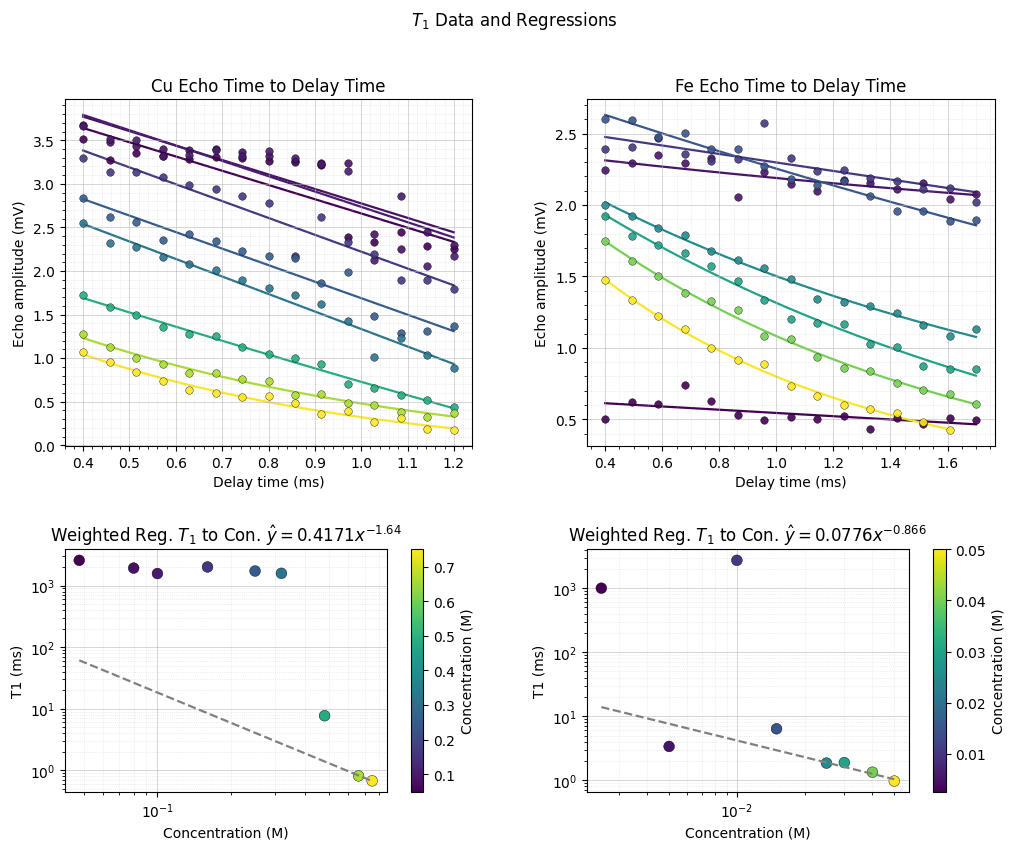

In [47]:
results_dict, conc_reg_stats = fit_and_plot({'Cu': cu_amp_data, 'Fe': fe_amp_data})

In [48]:
from pprint import pprint
pprint(conc_reg_stats)

{'Cu': {'Chi2': np.float64(0.0005949814785659811),
        'Chi2_red': np.float64(8.499735408085444e-05),
        'a': np.float64(0.41708466325202853),
        'b': np.float64(-1.6426220334785622),
        'delta a': np.float64(9.036580868692491),
        'delta b': np.float64(61.6438892810174),
        'r2': np.float64(-1.762684944593817)},
 'Fe': {'Chi2': np.float64(0.0020675291559189212),
        'Chi2_red': np.float64(0.0003445881926531535),
        'a': np.float64(0.07756571078971329),
        'b': np.float64(-0.8660057487683235),
        'delta a': np.float64(1.8249365409295695),
        'delta b': np.float64(7.269238947171127),
        'r2': np.float64(-0.25439117633275554)}}
